# Black Hole Extremal Calculation

The goal of the notebook is to look at how small mass black holes (of order 10's of planck mass) evolve. 

## Theory

Currently black holes of mass comparable to the mass of our sun all the way up to $10^{10} M_\star$. Although we have yet to observe black holes of mass much smaller than $M_\star$ the physics of black holes does not rule out these small mass black holes. Black holes can be described by just three parameters: Mass (M), Angular Momentum (J), and Charge (Q). From these there are 4 classifications of black holes.
- Schwarzchild Black Holes: Black holes with Mass M and $J = Q = 0$
- Kerr Black Holes: Black holes with Mass M and Angular Momentum J ($Q = 0$)
- Newman Black Holes: Black holes with mass M and charge Q ($J = 0$)
- Kerr-Newman Black Holes: Black holes with mass M, angular momentum J and charge Q.

Another property of black holes is that they shed away charge, angular momentum and mass through the process of Hawking Radiation. More important for this calculation is that Schwarzchild black holes will slowly gain angular momentum as they hawking radiate away. Since a black hole hawking radiates it can be modelled as a grey body (for the purposes of the code we will take out black holes to be perfect black bodies). For a black hole approximated as a black body, the temperature at which it radiates depends on the type of black hole. The temperature of a black hole can be generalized to

$$ T_{bh} = \frac{\kappa}{2\pi} $$

where $\kappa$ is the surface gravity of the black hole. 
- For a Schwarzchild black hole:
$$ T = \frac{m_p^2}{8\pi M} $$
- For a Kerr black hole:
$$ T = \frac{m_p^2}{4\pi M}\frac{\sqrt{1-a_{\star}^2}}{1+\sqrt{1-a_{\star}^2}} $$
where $m_p$ is the planck mass, and $a_\star = \frac{J}{M^2}$.

## Possible Probability Function

- Nomura: viable in the limit $\frac{J}{M^2} \ll 1$
    - $\rho_{\pm} = 1 \mp \frac{J}{M^2}$ 
- Squared
    - $\rho_{\pm} = \frac{1}{2}\left(1 \mp \frac{J}{M^2}\right)^2$

In [1]:
#!/usr/bin/python
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import scipy as sp
from scipy.misc import derivative
import scipy.integrate as integrate
import mpmath as mp
from scipy import interpolate
import os

In [2]:
rng = np.random.default_rng()
cdffunction = pd.read_csv(r'Data_Files/cdffunction.csv', header = None)
from scipy import interpolate
y_points = np.linspace(0.000001,12,10001)#Number is 10001 instead of 10k due to indexing differences between mathematica and python

def dist(x):
    invfunction = interpolate.splrep(cdffunction, y_points)
    return interpolate.splev(x, invfunction)

## Using $\rho = \frac{1}{2}\left(1-\frac{J}{M^2}\right)^2$ and Schwarzchild BH Temp

In [3]:
N = 49000 #Number of time steps
Nmc =1000 #Number of Monte Carlo Sims (number of black holes)
prob = rng.random(size = (Nmc,N))
change = dist(prob)

In [4]:
mass_i = 100 #in Planck Masses
Mass = np.zeros((Nmc+1,N+1))
J = np.zeros((Nmc+1,N+1))
astar = np.zeros((Nmc+1,N+1))
Mass[:,0] = mass_i
rand = rng.random(size = (Nmc,N))
for n in range(Nmc):
    for i in range(N):
        j = J[n,i]
        m = Mass[n,i]
        if m < 1:
            Mass[n,i:] = 1
            break
        else:
            astar[n,i] = abs(j/m/m)
            if abs(j/m/m) > 1:
                astar[n,i-1:] = 1
                J[n,i-1:] = j
                Mass[n,i-1:] = m
                break
            rho = 1/2*(1-2*j/m**2)**2
            temp = 1/8/np.pi/m #schwarzchild temperature
            Mass[n,i+1] = m-change[n,i]*temp 
            if rho > rand[n,i]:
                J[n,i+1] = j-change[n,i]*temp
            else:
                J[n,i+1] = j+change[n,i]*temp 
        
#Mass[Mass < 1] = 1;
#astar[astar > 1] = 1;
Mass = np.delete(Mass, -1, 0);
J = np.delete(J, -1, 0);
astar = np.delete(astar,-1,0);

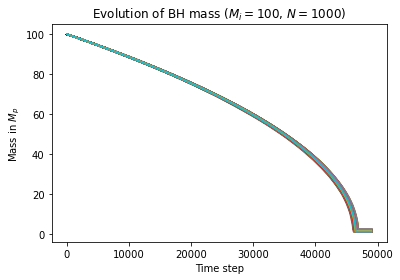

In [5]:
plt.plot(Mass.T)
#plt.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
plt.title(f'Evolution of BH mass ($M_i = {mass_i}$, $N = {Nmc}$)') 
plt.ylabel('Mass in $M_p$')
plt.xlabel('Time step')
#plt.xlim(45000,48000)
plt.show()

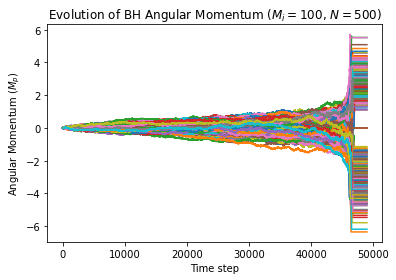

In [6]:
plt.plot(J.T)
plt.title(f'Evolution of BH Angular Momentum ($M_i = {mass_i}$, $N = {Nmc}$)') 
plt.ylabel('Angular Momentum ($M_p$)')
plt.xlabel('Time step')
plt.show()

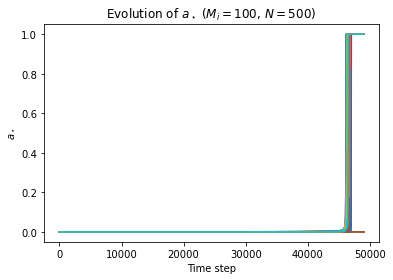

In [7]:
plt.plot(astar.T)
plt.title(f'Evolution of $a_\star$ ($M_i = {mass_i}$, $N = {Nmc}$)')
plt.ylabel('$a_\star$')
plt.xlabel('Time step')
#plt.xlim([46000,47000])
plt.show()

Text(0, 0.5, 'Mass ($m_p$)')

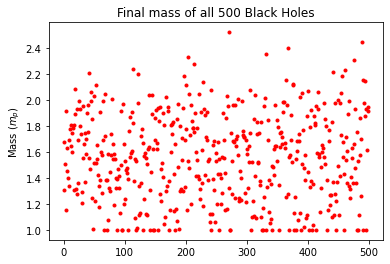

In [23]:
plt.plot(Mass[:,-1],'.', color = "red")
plt.title(f"Final mass of all {Nmc} Black Holes")
plt.ylabel("Mass ($m_p$)")
#print(Mass[:,-1])

In [7]:
ext = np.where(astar[:,-1] == 1)[0]
num = len(ext)
print(f"Number of extremal BH's: {num}, Percentage: {num/Nmc}")

Number of extremal BH's: 938, Percentage: 0.938


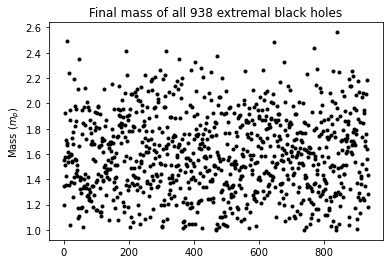

In [8]:
plt.plot(Mass[ext,-1],'.', color = "black")
plt.title(f"Final mass of all {num} extremal black holes")
plt.ylabel("Mass ($m_p$)")
plt.savefig("Plots/SchwarzT_square_extBH_Fmass.png")
plt.show()

In [10]:
Next = len(np.where((astar[:,-1]>0.98) & (astar[:,-1]<1))[0])
print(f"Number of near extreaml BH's: {Next}, Percentage: {Next/Nmc}")

Number of near extreaml BH's: 0, Percentage: 0.0


In [9]:
mean = np.mean(Mass[ext,-1])
print(f"The mean mass for {Nmc} extremal BH's: {mean} planck masses")
#mode = np.(astar[ext,-1])

The mean mass for 1000 extremal BH's: 1.5996467685446931 planck masses


### Reflections/Analysis

The problem with the old code was fixed where we saw bands of mass values for the extremal black holes. At least for this analysis (Schwarzchild BH temps and the Square $\rho$) 92 percent of the black holes end with a extremal mass above 1 $m_p$. It should be noted that for all of the the black holes they are either extremal or not extremal at all; non are near extremal (which I have defined as $0.98 < a_\star < 1$). This from my intuition is unexpected.

It also looks like the mean value of the extreaml BH's is around 1.6 planck masses. A planck mass is of order $10^{-5}$ grams.

We can find the cross section of these extremal black holes 

## Using $\rho = \frac{1}{2}\left(1-\frac{J}{M^2}\right)^2$ and Kerr BH Temp

In [10]:
N = 100000 #Number of time steps (This needs to be much much larger for Kerr Black holes compared to Schwarzchild!!!!)
Nmc =1000 #Number of Monte Carlo Sims (number of black holes)
prob = rng.random(size = (Nmc,N))
change = dist(prob)

In [11]:
mass_i = 100 #in Planck Masses
Mass = np.zeros((Nmc+1,N+1))
J = np.zeros((Nmc+1,N+1))
astar = np.zeros((Nmc+1,N+1))
Mass[:,0] = mass_i
rand = rng.random(size = (Nmc,N))
for n in range(Nmc):
    for i in range(N):
        j = J[n,i]
        m = Mass[n,i]
        a = abs(j/m/m)
        if m < 1:
            Mass[n,i:] = 1
            break
        else:
            astar[n,i] = a
            if abs(a) > 1:
                astar[n,i:] = 1
                J[n,i-1:] = j
                Mass[n,i-1:] = m
                break
            rho = 1/2*(1-2*j/m**2)**2
            kerrT = 1/8/np.pi/m*(np.sqrt(1-a**2))/(1+np.sqrt(1-a**2)) #Kerr temperature
            Mass[n,i+1] = m-change[n,i]*kerrT 
            if rho > rand[n,i]:
                J[n,i+1] = j-change[n,i]*kerrT
            else:
                J[n,i+1] = j+change[n,i]*kerrT
        
#Mass[Mass < 1] = 1;
#astar[astar > 1] = 1;
Mass = np.delete(Mass, -1, 0);
J = np.delete(J, -1, 0);
astar = np.delete(astar,-1,0);

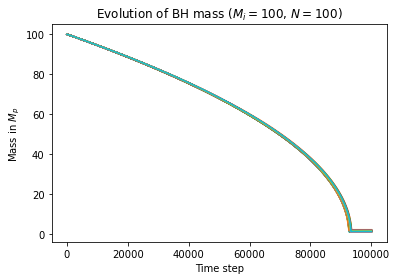

In [9]:
plt.plot(Mass.T)
#plt.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
plt.title(f'Evolution of BH mass ($M_i = {mass_i}$, $N = {Nmc}$)') 
plt.ylabel('Mass in $M_p$')
plt.xlabel('Time step')
#plt.xlim(45000,48000)
plt.show()

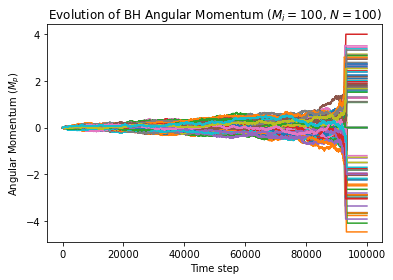

In [10]:
plt.plot(J.T)
plt.title(f'Evolution of BH Angular Momentum ($M_i = {mass_i}$, $N = {Nmc}$)') 
plt.ylabel('Angular Momentum ($M_p$)')
plt.xlabel('Time step')
plt.show()

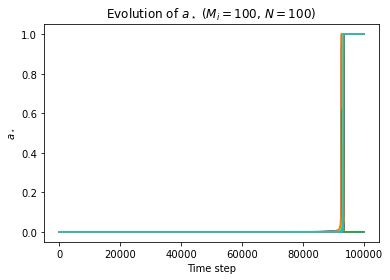

In [11]:
plt.plot(astar.T)
plt.title(f'Evolution of $a_\star$ ($M_i = {mass_i}$, $N = {Nmc}$)')
plt.ylabel('$a_\star$')
plt.xlabel('Time step')
#plt.xlim([46000,47000])
plt.show()

In [13]:
ext = np.where(astar[:,-1] == 1)[0]
num = len(ext)
print(f"Number of extremal BH's: {num}, Percentage: {num/Nmc*100}")

Number of extremal BH's: 922, Percentage: 92.2


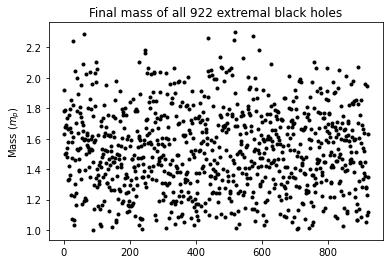

In [14]:
plt.plot(Mass[ext,-1],'.', color = "black")
plt.title(f"Final mass of all {num} extremal black holes")
plt.ylabel("Mass ($m_p$)")
plt.savefig("Plots/KerrT_square_extBH_Fmass.png")
plt.show()

In [15]:
Next = len(np.where((astar[:,-1]>0.98) & (astar[:,-1]<1))[0])
print(f"Number of near extreaml BH's: {Next}, Percentage: {Next/Nmc}")

Number of near extreaml BH's: 0, Percentage: 0.0


In [15]:
mean = np.mean(Mass[ext,-1])
print(f"The mean mass for {num} extremal BH's: {mean} planck masses")
#mode = np.(astar[ext,-1])

The mean mass for 922 extremal BH's: 1.5271280492071324 planck masses


In [26]:
#data check
N = 50000
3*N*2*8 / 1024**3

0.0022351741790771484

# Old Code

In [ ]:
cdffunction = pd.read_csv(r'C:\Users\quinn\Case_Western\Black_Hole_Extremal\Data_Files\cdffunction.csv', header = None)
from scipy import interpolate
y_points = np.linspace(0.000001,12,10001)#Number is 10001 instead of 10k due to indexing differences between mathematica and python

def change(x):
    invfunction = interpolate.splrep(cdffunction, y_points)
    return interpolate.splev(x, invfunction)

In [ ]:
runs = 50
Mass_array = np.zeros(runs)
J_array =np.zeros(runs)
astar_array = np.zeros(runs)
final_mass = np.zeros(runs)
spin = 1 #spin of the emitted particle
temp = 1/8/math.pi #termperature of the black hole

#Note: Throughout the code we are using a = j/m^2 and c = 1

for run in range(runs):
    initial_mass = 10. #in units of MeV
    n = 1000000

    mass = [initial_mass]
    ang = [0.]
    #astar = [0.]
    for i in range(n):
        x = mass[i] 
        j = ang[i]
        a = j/x**2
        probability = 1./2.*(1. - a) #spin up probability
        rmass = np.random.random()
        x -= change(rmass)*temp/x
        if x > 0. and abs(a) < 1.:
            rspin = np.random.random()
            if rspin <= probability:
                j += spin
            else:
                j -= spin
            mass.append(x)
            ang.append(j)
            astar.append(a)
        else:
            if x < 0:
                final_mass.append(0)
            else:
                final_mass.append(x)
            if abs(a) > 1.:
                astar.append(1)
            else:
                astar.append(a)
            break
    Mass_array.append(mass)
    J_array.append(ang)
    astar_array.append(astar)

Mass_matrix = pd.DataFrame(Mass_array)
astar_matrix = pd.DataFrame(astar_array)
J_matrix = pd.DataFrame(J_array)
Final_Mass = pd.DataFrame(final_mass)

In [ ]:
#plt.figure(1)
#for index, row in Mass_matrix.iterrows():
 #   plt.plot(row, marker = '.', label = 'mass{0}'.format(index))
plt.figure (2)
for index, row in astar_matrix.iterrows():
    plt.plot(row, marker = 'o', label = 'astar{0}'.format(index))
plt.axhline(c = 'b', linestyle = '--')
plt.figure(3)
plt.plot(Final_Mass, marker = 'o', linewidth = 0, label = 'final mass')
plt.legend()
plt.show()